# NASA FIRMS Wildfire Data Downloader
This Code access and download historical wildfire data derived from VIIRS-SNPP and MODIS imagery via NASA's FIRMS satellite system.


### Incorporation of NASA FIRMS Wildfire Data

#### Data Acquisition:

NASA's Fire Information for Resource Management System (FIRMS) provides near real-time active fire data from the MODIS and VIIRS instruments, offering a comprehensive view of wildfire activity. To incorporate this data, we implemented an automated process to download fire event records for Morocco, spanning from 2010 to 2023, for both MODIS and VIIRS-SNPP instruments. The data was retrieved using a Python script, demonstrating the use of the Requests library for HTTP requests to download CSV files directly from the FIRMS archive. This approach ensured we systematically captured a consistent dataset across the study period (NASA FIRMS, 2023).

#### Data Loading and Processing:

The downloaded data comprises several key attributes, including latitude, longitude, brightness temperatures, scan and track sizes, acquisition date and time, satellite and instrument identifiers, confidence levels, fire radiative power, and day-night indicators. These attributes provide a detailed account of each detected fire event, essential for our analysis.

The FIRMS data was loaded into pandas DataFrames for MODIS and VIIRS separately (McKinney, 2010). We concatenated annual data files to create comprehensive datasets for each instrument, ensuring a continuous record from 2010 to 2023. These datasets were then processed to reset their indices, maintaining data integrity and order.

#### Geospatial Analysis:

To enhance our wildfire risk assessment, we integrated the FIRMS wildfire data with geographical information using the OSMnx library to identify the nearest buildings or significant landmarks to the fire events (Boeing, 2017). This integration provided additional context on the potential human impact and the relevance of each fire event within populated or critical areas.

Additionally, we employed spatial analysis techniques to associate each fire event with the nearest meteorological station data. This association allowed us to correlate wildfire occurrences with local weather conditions, leveraging distance calculations through methods like the Haversine formula, geodesic distances, and Euclidean distances, depending on the analysis's specificity requirements.

#### Integration with Environmental and Meteorological Datasets:

The enriched FIRMS data, now augmented with nearest building and weather station information, was merged with other datasets in our study, including population density, NDVI, soil moisture, and GSOD weather data. This comprehensive integration created a multidimensional dataset, facilitating a nuanced analysis of the factors influencing wildfire risks and occurrences in Morocco.

The methodology employed for incorporating NASA FIRMS wildfire data into our study underscores the importance of detailed fire event data and geographical context in understanding and predicting wildfire dynamics. By leveraging advanced data acquisition and processing techniques, along with spatial analysis, we significantly enhance the predictive capability of our models, contributing to more effective wildfire management strategies.

#### References:
- Boeing, G. (2017). OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks. *Computers, Environment and Urban Systems*, 65, 126-139. DOI: 10.1016/j.compenvurbsys.2017.05.004.
- McKinney, W. (2010). Data Structures for Statistical Computing in Python. In *Proceedings of the 9th Python in Science Conference* (pp. 51-56).
- NASA FIRMS. (2023). Fire Information for Resource Management System. Retrieved from https://firms.modaps.eosdis.nasa.gov/.



In [3]:
FIRMS_DATA_DIR="./Data/WildFireHist/FIRMS"


The following script downloads the 1:110m Cultural Vectors data, which includes a shapefile for the countries, and then extracts it into the designated directory:

In [49]:
import requests
#! mkdir -p ./Data/WildFireHist/FIRMS
def firms_download_file(data_type, country, year):
    url = f"https://firms.modaps.eosdis.nasa.gov/data/country/{data_type}/{year}/{data_type}_{year}_{country}.csv"
    save_path = f"{FIRMS_DATA_DIR}/{data_type}_{year}_{country}.csv"
    
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
    else:
        print(f"Unable to download file. Server responded with status code: {response.status_code}")
for year in range(2022, 2024):
    firms_download_file('modis', 'Morocco', str(year))
    firms_download_file('viirs-snpp', 'Morocco', str(year))
# firms_download_file('modis', 'Morocco', '2022')
# data_type : modis/viirs-snpp

Unable to download file. Server responded with status code: 404
Unable to download file. Server responded with status code: 404
Unable to download file. Server responded with status code: 404


In [50]:
!ls ./Data/WildFireHist/FIRMS

modis_2010_Morocco.csv
modis_2011_Morocco.csv
modis_2012_Morocco.csv
modis_2013_Morocco.csv
modis_2014_Morocco.csv
modis_2015_Morocco.csv
modis_2016_Morocco.csv
modis_2017_Morocco.csv
modis_2018_Morocco.csv
modis_2019_Morocco.csv
modis_2020_Morocco.csv
modis_2021_Morocco.csv
modis_2022_Morocco.csv
viirs-snpp_2012_Morocco.csv
viirs-snpp_2013_Morocco.csv
viirs-snpp_2014_Morocco.csv
viirs-snpp_2015_Morocco.csv
viirs-snpp_2016_Morocco.csv
viirs-snpp_2017_Morocco.csv
viirs-snpp_2018_Morocco.csv
viirs-snpp_2019_Morocco.csv
viirs-snpp_2020_Morocco.csv
viirs-snpp_2021_Morocco.csv


In [4]:
import pandas as pd
YEAR = 2021
COUNTRY = 'Morocco'

df_modis=pd.read_csv(f"{FIRMS_DATA_DIR}/modis_{YEAR}_{COUNTRY}.csv")
df_viirs=pd.read_csv(f"{FIRMS_DATA_DIR}/viirs-snpp_{YEAR}_{COUNTRY}.csv")

In [61]:
## range of datesdata loading
df_modis=pd.DataFrame()
df_viirs=pd.DataFrame()
for year in range(2010, 2024):
    try:
        df_modis = pd.concat([df_modis, pd.read_csv(f"{FIRMS_DATA_DIR}/modis_{year}_{COUNTRY}.csv")])
    except: 
        print(f"no modis data for {year}")
    try:
        df_viirs = pd.concat([df_viirs, pd.read_csv(f"{FIRMS_DATA_DIR}/viirs-snpp_{year}_{COUNTRY}.csv")])
    except:
        print(f"no viirs data for {year}")

df_viirs = df_viirs.reset_index(drop=True)
df_modis = df_modis.reset_index(drop=True)

no viirs data for 2010
no viirs data for 2011
no viirs data for 2022
no modis data for 2023
no viirs data for 2023


In [72]:
df_modis.to_parquet(f"{FIRMS_DATA_DIR}/modis_{COUNTRY}_2010_2022.parquet")
df_viirs.to_parquet(f"{FIRMS_DATA_DIR}/viirs-snpp_{COUNTRY}_2012_2021.parquet")

In [69]:
df_viirs.acq_time.max()

1506

In [11]:
df_fire=df_modis[df_modis["confidence"]>90].copy()

In [74]:
df_firms = pd.concat([df_modis, df_viirs]).sort_values(by="acq_date").reset_index(drop=True)

Each of these columns in the NASA FIRMS data represents:

- **Latitude**: This is the latitude coordinate of the center of the nominal 375 m fire pixel.

- **Longitude**: This is the longitude coordinate of the center of the nominal 375 m fire pixel.

- **Bright_ti4**: This is the brightness temperature of the fire pixel measured in Kelvin, as detected by the VIIRS I-4 channel.

- **Scan**: This represents the along-scan pixel size. The algorithm produces approximately 375 m pixels at nadir (the point directly below the satellite). Scan and track reflect the actual pixel size.

- **Track**: This represents the along-track pixel size. Like the scan, the algorithm produces approximately 375 m pixels at nadir.

- **Acq_date**: This is the date of the VIIRS or MODIS acquisition, depending on the satellite.

- **Acq_time**: This is the time of acquisition or overpass of the satellite, given in Coordinated Universal Time (UTC).

- **Satellite**: This indicates which satellite made the acquisition. For example, "N" represents the Suomi National Polar-orbiting Partnership (Suomi NPP), "1" represents NOAA-20 (designated JPSS-1 prior to launch), "A" represents Aqua, and "T" represents Terra.

- **Instrument**: This column would specify the instrument used for the data acquisition.

- **Confidence**: This value, given as a percentage between 0 and 100, is based on a collection of intermediate algorithm values and indicates the confidence level of the fire detection.

- **Version**: This would indicate the version of the data or the algorithm used for fire detection.

- **Bright_ti5**: This is another brightness temperature measurement, but from the VIIRS I-5 channel.

- **FRP**: This stands for Fire Radiative Power, a measure of the radiant heat output of the fire.

- **Daynight**: This indicates whether the satellite overpass and data acquisition occurred during the day or at night.

- **Type**: This column would specify the type of the data or the event detected, such as a fire or thermal anomaly.

These columns provide a comprehensive set of data for each fire event detected by the satellite, allowing for detailed analysis and tracking of fire activity.

In [79]:
df_firms['confidence'] = pd.to_numeric(df_firms['confidence'], errors='coerce')
df_firms.to_feather(f"{FIRMS_DATA_DIR}/all_firms_data_{COUNTRY}_2010_2022.feather")

In [15]:
import pandas as pd
import osmnx as ox

# Example dataframe
# df = pd.DataFrame({'lat': [latitude_values], 'lon': [longitude_values]})

def find_nearest_objects(df):
    # Configure osmnx to use footprints (buildings, etc.)
    ox.config(use_cache=True)
    
    nearest_objects = []
    
    for index, row in df.iterrows():
        # Get latitude and longitude
        lat, lon =  row['latitude'], row['longitude']
        
        # Find nearest building, road, park, etc. You might need to adjust this part depending on your exact needs
        # For example, to find the nearest building:
        nearest_building = ox.distance.nearest_nodes(ox.graph_from_point((lat, lon), distance=1000), lon, lat)
        
        # Store information about the nearest object
        nearest_objects.append(nearest_building)
    
    # Add the nearest object info to the dataframe
    df['nearest_object'] = nearest_objects
    
    return df

# Assuming you have your dataframe ready, you would call it like this:
# df_with_nearest = find_nearest_objects(df)


In [25]:
import pandas as pd
import osmnx as ox

# Ensure osmnx uses its cache to speed up repeated queries
ox.config(use_cache=True)

def find_nearest_objects_with_names(df):
    # Initialize a list to hold the nearest objects and their names
    nearest_objects_info = []
    
    for index, row in df.iterrows():
        # Get latitude and longitude
        lat, lon = row['latitude'], row['longitude']
        
        # Specify the types of objects you're interested in
        # For buildings, you might use something like 'building'
        gdf = ox.geometries_from_point((lat, lon), tags={'building': True}, dist=10000)
        
        if not gdf.empty:
            # If there are buildings found, select the nearest one
            # Calculate distances
            gdf['distance'] = gdf.geometry.distance(ox.utils.geocode(f"{lat}, {lon}"))
            nearest_building = gdf.iloc[gdf['distance'].argmin()]
            
            # Extract name if available, otherwise use a default identifier
            object_name = nearest_building.get('name', 'Unnamed Building')
            
            # Append the name and other info as needed
            nearest_objects_info.append(object_name)
        else:
            # Handle the case where no building is found within the distance
            nearest_objects_info.append("No nearby object found")
    
    # Add the nearest object info to the dataframe
    df['nearest_object_name'] = nearest_objects_info
    
    return df

# Example usage, assuming you have a dataframe 'df' ready:
# df_with_nearest_names = find_nearest_objects_with_names(df)


C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2681232769.py:5: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True)


In [18]:
import osmnx as ox
import pandas as pd

# Configure osmnx
ox.config(use_cache=True)

def find_nearest_object_name(lat, lon):
    """
    Find the nearest object to a given latitude and longitude and return its name.
    """
    # Define the point and the distance (in meters)
    point = (lat, lon)
    distance = 1000  # Search within 1000 meters
    
    # Query for nearby geometries (including buildings, parks, etc.)
    gdf = ox.geometries.geometries_from_point(point, dist=distance)
    
    # If no geometries are found, return a message indicating this
    if gdf.empty:
        return "No nearby objects found"
    
    # Calculate the distance to each geometry from the given point
    gdf['distance'] = gdf.distance(ox.utils.geodesic_point_buffer(lat, lon, distance))
    nearest_object = gdf.sort_values('distance').iloc[0]
    
    # Attempt to retrieve the name of the nearest object, or use a default value if not available
    object_name = nearest_object.get('name', 'Unnamed Object')
    
    return object_name

# Example usage for a single point
# Replace these latitude and longitude with one from your dataframe
# lat, lon = 40.748817, -73.985428  # Example coordinates (Empire State Building vicinity)
# object_name = find_nearest_object_name(lat, lon)
# print(f"The nearest object's name is: {object_name}")

# To apply this function to each row in your DataFrame, you can do:
# df['nearest_object_name'] = df.apply(lambda row: find_nearest_object_name(row['lat'], row['lon']), axis=1)


C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2029173193.py:5: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True)


In [82]:
df_firms 

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,bright_ti4,bright_ti5
0,32.2037,-4.3729,308.8,1.1,1.1,2010-01-09,1324,Aqua,MODIS,68.0,6.03,288.4,9.6,D,0,NaN,NaN
1,32.2056,-4.3611,305.0,1.1,1.1,2010-01-09,1324,Aqua,MODIS,60.0,6.03,290.3,6.9,D,0,NaN,NaN
2,32.4321,-8.4256,308.7,1.1,1.0,2010-03-14,223,Aqua,MODIS,75.0,6.03,279.8,14.7,N,0,NaN,NaN
3,35.0263,-5.9445,309.8,1.0,1.0,2010-04-03,1120,Terra,MODIS,58.0,6.03,296.9,5.7,D,0,NaN,NaN
4,32.9345,-8.4878,324.4,1.9,1.4,2010-04-06,1151,Terra,MODIS,79.0,6.03,296.9,42.5,D,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29145,28.3791,-11.0533,315.0,1.1,1.1,2022-12-19,1359,Aqua,MODIS,64.0,6.03,301.6,7.8,D,0,NaN,NaN
29146,30.1692,-9.4675,306.6,1.5,1.2,2022-12-23,1050,Terra,MODIS,56.0,6.03,293.8,7.4,D,0,NaN,NaN
29147,30.1660,-9.4747,307.5,1.5,1.2,2022-12-23,1050,Terra,MODIS,59.0,6.03,294.4,9.5,D,0,NaN,NaN
29148,31.5474,-7.9873,306.6,1.0,1.0,2022-12-28,1059,Terra,MODIS,64.0,6.03,293.7,4.9,D,0,NaN,NaN


## Nearest distance to stations

In [85]:
morocco_stations=pd.read_feather('Data/morocco_stations.feather')
morocco_stations

,station_number,station_name,country,lat,lon
0,601154,SIDI SLIMANE &,MO,34.233,-6.050
1,601250,TOUAHAR,MO,34.200,-3.833
2,601300,RABAT,MO,34.000,-6.833
3,601360,SIDI SLIMANE,MO,34.233,-6.050
4,601400,FES,MO,34.033,-4.983
...,...,...,...,...,...
61,603400,NADOR-AROUI,MO,34.983,-3.017
62,603180,SANIAT RMEL,MO,35.594,-5.320
63,601460,MOHAMMEDIA,MO,33.717,-7.400
64,601200,KENITRA (RMAFB),MO,34.300,-6.600


In [92]:
nearest_stations

NameError: name 'nearest_stations' is not defined

In [101]:
!pip install geopy haversine

c:\DevLib\Conda\envs\TF\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=3>
  return process_handler(cmd, _system_body)
c:\DevLib\Conda\envs\TF\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=4>
  return process_handler(cmd, _system_body)
c:\DevLib\Conda\envs\TF\lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)


In [108]:
from scipy.spatial import distance
import pandas as pd
import numpy as np

# Assuming df_firms and morocco_stations are defined and their latitude/longitude columns are converted to numeric as in your snippet

# Check for NaN values and decide how to handle them. Here, we'll drop rows with NaN in critical columns:
df_firms.dropna(subset=['latitude', 'longitude'], inplace=True)
morocco_stations.dropna(subset=['lat', 'lon'], inplace=True)

# Define the function to find the nearest station for each row in df_firms
def find_nearest_0(row):
    coords_firm = row[['latitude', 'longitude']].values
    coords_stations = morocco_stations[['lat', 'lon']].values
    distances = distance.cdist([coords_firm], coords_stations, 'euclidean').squeeze()
    nearest_station_index = distances.argmin()
    return morocco_stations.iloc[nearest_station_index]

from haversine import haversine

def find_nearest_1(row):
    coords_firm = row[['latitude', 'longitude']].values
    coords_stations = morocco_stations[['lat', 'lon']].values
    distances = [haversine(coords_firm, coord_station) for coord_station in coords_stations]
    nearest_station_index = np.argmin(distances)
    return morocco_stations.iloc[nearest_station_index]

from geopy.distance import geodesic

def find_nearest(row):
    coords_firm = (row['latitude'], row['longitude'])
    distances = [geodesic(coords_firm, (station['lat'], station['lon'])).kilometers for _, station in morocco_stations.iterrows()]
    nearest_station_index = np.argmin(distances)
    return morocco_stations.iloc[nearest_station_index]

# Apply the function to each row in df_firms
nearest_stations = df_firms.apply(find_nearest, axis=1)

# Depending on your end goal, you might join on specific columns or merge the entire nearest_stations DataFrame:
# For a full join, ensure nearest_stations is a DataFrame with a consistent structure
# df_firms = df_firms.reset_index()  # Reset index if necessary to ensure a common column for joining
# nearest_stations.reset_index(inplace=True, drop=True)  # Reset index to align with df_firms

# Join df_firms with nearest_stations. Adjust this step based on your specific requirements
df_firms_stations = pd.concat([df_firms, nearest_stations], axis=1)
# df_firms_stations.pop('index')
df_firms_stations

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,daynight,type,bright_ti4,bright_ti5,nearest_station_index,station_number,station_name,country,lat,lon
0,32.2037,-4.3729,308.8,1.1,1.1,2010-01-09,1324,Aqua,MODIS,68.0,...,D,0,NaN,NaN,9,601954,ERRACHIDIA,MO,31.967,-4.417
1,32.2056,-4.3611,305.0,1.1,1.1,2010-01-09,1324,Aqua,MODIS,60.0,...,D,0,NaN,NaN,9,601954,ERRACHIDIA,MO,31.967,-4.417
2,32.4321,-8.4256,308.7,1.1,1.0,2010-03-14,223,Aqua,MODIS,75.0,...,N,0,NaN,NaN,11,602051,BEN GUERIR AIR BASE,MO,32.117,-7.883
3,35.0263,-5.9445,309.8,1.0,1.0,2010-04-03,1120,Terra,MODIS,58.0,...,D,0,NaN,NaN,34,601050,LARACHE,MO,35.150,-6.100
4,32.9345,-8.4878,324.4,1.9,1.4,2010-04-06,1151,Terra,MODIS,79.0,...,D,0,NaN,NaN,7,601650,EL JADIDA,MO,33.233,-8.517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29145,28.3791,-11.0533,315.0,1.1,1.1,2022-12-19,1359,Aqua,MODIS,64.0,...,D,0,NaN,NaN,60,602850,PLAGE BLANCHE,MO,28.448,-11.161
29146,30.1692,-9.4675,306.6,1.5,1.2,2022-12-23,1050,Terra,MODIS,56.0,...,D,0,NaN,NaN,15,697744,TIFNIT,MO,30.317,-9.417
29147,30.1660,-9.4747,307.5,1.5,1.2,2022-12-23,1050,Terra,MODIS,59.0,...,D,0,NaN,NaN,15,697744,TIFNIT,MO,30.317,-9.417
29148,31.5474,-7.9873,306.6,1.0,1.0,2022-12-28,1059,Terra,MODIS,64.0,...,D,0,NaN,NaN,52,602300,MENARA,MO,31.607,-8.036


In [110]:
df_firms_stations.station_number.equals(morrocan_wildfire_df.station_number)

False

In [107]:
df_firms_stations

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,daynight,type,bright_ti4,bright_ti5,nearest_station_index,station_number,station_name,country,lat,lon
0,32.2037,-4.3729,308.8,1.1,1.1,2010-01-09,1324,Aqua,MODIS,68.0,...,D,0,NaN,NaN,9,601954,ERRACHIDIA,MO,31.967,-4.417
1,32.2056,-4.3611,305.0,1.1,1.1,2010-01-09,1324,Aqua,MODIS,60.0,...,D,0,NaN,NaN,9,601954,ERRACHIDIA,MO,31.967,-4.417
2,32.4321,-8.4256,308.7,1.1,1.0,2010-03-14,223,Aqua,MODIS,75.0,...,N,0,NaN,NaN,11,602051,BEN GUERIR AIR BASE,MO,32.117,-7.883
3,35.0263,-5.9445,309.8,1.0,1.0,2010-04-03,1120,Terra,MODIS,58.0,...,D,0,NaN,NaN,34,601050,LARACHE,MO,35.150,-6.100
4,32.9345,-8.4878,324.4,1.9,1.4,2010-04-06,1151,Terra,MODIS,79.0,...,D,0,NaN,NaN,7,601650,EL JADIDA,MO,33.233,-8.517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29145,28.3791,-11.0533,315.0,1.1,1.1,2022-12-19,1359,Aqua,MODIS,64.0,...,D,0,NaN,NaN,60,602850,PLAGE BLANCHE,MO,28.448,-11.161
29146,30.1692,-9.4675,306.6,1.5,1.2,2022-12-23,1050,Terra,MODIS,56.0,...,D,0,NaN,NaN,15,697744,TIFNIT,MO,30.317,-9.417
29147,30.1660,-9.4747,307.5,1.5,1.2,2022-12-23,1050,Terra,MODIS,59.0,...,D,0,NaN,NaN,15,697744,TIFNIT,MO,30.317,-9.417
29148,31.5474,-7.9873,306.6,1.0,1.0,2022-12-28,1059,Terra,MODIS,64.0,...,D,0,NaN,NaN,52,602300,MENARA,MO,31.607,-8.036


In [96]:
import pandas as pd
import numpy as np

# Assuming df_firms and morocco_stations are already defined and loaded

# Function to calculate Euclidean distance
def calc_euclidean_dist(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Initialize a column to store the index of the nearest station
df_firms['nearest_station_index'] = None

for index, firm in df_firms.iterrows():
    # Calculate distances to all stations
    distances = morocco_stations.apply(lambda station: calc_euclidean_dist(firm['latitude'], firm['longitude'], station['lat'], station['lon']), axis=1)
    
    # Find the index of the nearest station
    nearest_station_index = distances.idxmin()
    
    # Update the nearest_station_index in df_firms
    df_firms.at[index, 'nearest_station_index'] = nearest_station_index

# Convert the nearest_station_index to int for merging
df_firms['nearest_station_index'] = df_firms['nearest_station_index'].astype(int)

# Merge based on nearest station index
morrocan_wildfire_df = pd.merge(df_firms, morocco_stations, left_on='nearest_station_index', right_index=True, how='left')

morrocan_wildfire_df.drop('nearest_station_index', axis=1, inplace=True)  # Optional: drop the index column if not needed


In [97]:
morrocan_wildfire_df

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,frp,daynight,type,bright_ti4,bright_ti5,station_number,station_name,country,lat,lon
0,32.2037,-4.3729,308.8,1.1,1.1,2010-01-09,1324,Aqua,MODIS,68.0,...,9.6,D,0,NaN,NaN,601954,ERRACHIDIA,MO,31.967,-4.417
1,32.2056,-4.3611,305.0,1.1,1.1,2010-01-09,1324,Aqua,MODIS,60.0,...,6.9,D,0,NaN,NaN,601954,ERRACHIDIA,MO,31.967,-4.417
2,32.4321,-8.4256,308.7,1.1,1.0,2010-03-14,223,Aqua,MODIS,75.0,...,14.7,N,0,NaN,NaN,602051,BEN GUERIR AIR BASE,MO,32.117,-7.883
3,35.0263,-5.9445,309.8,1.0,1.0,2010-04-03,1120,Terra,MODIS,58.0,...,5.7,D,0,NaN,NaN,601050,LARACHE,MO,35.150,-6.100
4,32.9345,-8.4878,324.4,1.9,1.4,2010-04-06,1151,Terra,MODIS,79.0,...,42.5,D,0,NaN,NaN,601650,EL JADIDA,MO,33.233,-8.517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29145,28.3791,-11.0533,315.0,1.1,1.1,2022-12-19,1359,Aqua,MODIS,64.0,...,7.8,D,0,NaN,NaN,602850,PLAGE BLANCHE,MO,28.448,-11.161
29146,30.1692,-9.4675,306.6,1.5,1.2,2022-12-23,1050,Terra,MODIS,56.0,...,7.4,D,0,NaN,NaN,697744,TIFNIT,MO,30.317,-9.417
29147,30.1660,-9.4747,307.5,1.5,1.2,2022-12-23,1050,Terra,MODIS,59.0,...,9.5,D,0,NaN,NaN,697744,TIFNIT,MO,30.317,-9.417
29148,31.5474,-7.9873,306.6,1.0,1.0,2022-12-28,1059,Terra,MODIS,64.0,...,4.9,D,0,NaN,NaN,602300,MENARA,MO,31.607,-8.036


In [95]:
morrocan_wildfire_df.to_feather(f"{FIRMS_DATA_DIR}/all_firms_data_{COUNTRY}_2010_2022_with_nearest_station.feather")

In [115]:
morrocan_wildfire_df.to_parquet("Data/FinalDataset/morrocan_wildfire_df.parquet")

In [37]:
import osmnx as ox
import pandas as pd
from shapely.geometry import Point

# Configure osmnx to use cache and logs
ox.config(use_cache=True, log_console=True)

def find_nearest_object_name(lat, lon):
    """
    Find the nearest object to a given latitude and longitude and return its name.
    """
    # Define the search point using latitude and longitude
    point = Point(lon, lat)
    distance = 15000  # Search within this radius in meters
    
    # Define tags to search for (buildings, parks, etc.)
    # Adjust these tags as necessary for your specific needs
    tags = {"building": True}
    
    # Query for nearby geometries within the specified distance using the tags
    gdf = ox.geometries.geometries_from_point((lat, lon), tags=tags, dist=distance)
    
    if gdf.empty:
        return "No nearby objects found"
    
    # Calculate distances to the provided point
    gdf['distance'] = gdf.centroid.distance(point)
    
    # Find the nearest object by sorting by distance
    nearest_object = gdf.iloc[gdf['distance'].argmin()]
    
    # Attempt to get the name of the object, with a fallback for unnamed objects
    object_name = nearest_object.get('name', 'Unnamed Object')
    
    return {"name": object_name, "distance": nearest_object['distance']}

# Example usage for a single point
lat, lon = 33.7978, -5.4410	  # Example coordinates (Empire State Building vicinity)
object_name = find_nearest_object_name(lat, lon)
distance = object_name['distance']  
object_name = object_name['name']
print(f"The nearest object's name is: {object_name} at a distance of {distance} meters")


C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2794482017.py:6: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2794482017.py:21: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  gdf = ox.geometries.geometries_from_point((lat, lon), tags=tags, dist=distance)


The nearest object's name is: Meknes Carpet at a distance of 0.05852682468665965 meters


C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2794482017.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance'] = gdf.centroid.distance(point)
C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2794482017.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance'] = gdf.centroid.distance(point)


In [46]:
import osmnx as ox

# Configure osmnx to use cache and logs
ox.config(use_cache=True, log_console=True)

# Specify the location and name of the area or use bounding box
place_name = "Morocco"

# Download data for buildings (or adjust tags for other features)
tags = {'building': True}
gdf = ox.geometries_from_place(place_name, tags=tags)

# Convert all columns with non-primitive types (e.g., lists or dicts) to strings
for col in gdf.columns:
    if gdf[col].apply(type).eq(list).any() or gdf[col].apply(type).eq(dict).any():
        gdf[col] = gdf[col].astype(str)

# Save the GeoDataFrame to a file for later use
gdf.to_file("./Data/GeoData/OpenMapStreet/morocco_buildings.gpkg", driver="GPKG")


C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2356610048.py:4: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\2356610048.py:11: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  gdf = ox.geometries_from_place(place_name, tags=tags)
c:\DevLib\Conda\envs\TF\lib\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 371 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj =

AttributeError: 'property' object has no attribute 'get'

In [44]:
! mkdir ./Data/GeoData/OpenMapStreet

The syntax of the command is incorrect.


In [40]:
import osmnx as ox
import pandas as pd
from shapely.geometry import Point
from geopy.distance import geodesic

# Configure osmnx to use cache and logs
ox.config(use_cache=True, log_console=True)

def find_nearest_object_name(lat, lon):
    """
    Find the nearest object to a given latitude and longitude and return its name and distance.
    """
    # Define the search point using latitude and longitude
    point = (lat, lon)
    distance = 7000  # Search within this radius in meters
    
    # Define tags to search for (buildings, parks, etc.)
    tags = {"building": True}
    
    # Query for nearby geometries within the specified distance using the tags
    gdf = ox.geometries.geometries_from_point(point, tags=tags, dist=distance)
    
    if gdf.empty:
        return {"name": "No nearby objects found", "distance": None}
    
    # Initialize minimum distance and object name
    min_distance = float('inf')
    nearest_object_name = "Unnamed Object"
    
    # Iterate through each geometry to find the closest
    for _, row in gdf.iterrows():
        object_point = (row.geometry.centroid.y, row.geometry.centroid.x)  # (lat, lon)
        current_distance = geodesic(point, object_point).meters
        
        if current_distance < min_distance:
            min_distance = current_distance
            nearest_object_name = row.get('name', 'Unnamed Object')
    
    return {"name": nearest_object_name, "distance": min_distance}

# Example usage for a single point
lat, lon = 33.7978, -5.4410  # Replace with actual coordinates
object_info = find_nearest_object_name(lat, lon)
distance = object_info['distance']
object_name = object_info['name']
print(f"The nearest object's name is: {object_name} at a distance of {distance:.2f} meters")


C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\727574244.py:7: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)
C:\Users\ayoub\AppData\Local\Temp\ipykernel_22084\727574244.py:21: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.
  gdf = ox.geometries.geometries_from_point(point, tags=tags, dist=distance)


The nearest object's name is: nan at a distance of 6044.70 meters


In [112]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Simulated DataFrame with longitude and latitude
data = {
    'lon': [-122.4194, 100.6331, 12.4964],
    'lat': [37.7749, 13.7563, 41.9028]
}
df = pd.DataFrame(data)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

# Assuming coastlines is your coastline GeoDataFrame loaded previously
# Ensure coastlines is a single MultiPoint geometry for efficiency
coastline_points = MultiPoint(coastlines.geometry.unary_union)

# Initialize columns for the nearest sea point's lon and lat
gdf['lon_min_to_sea'] = None
gdf['lat_min_to_sea'] = None

for index, row in gdf.iterrows():
    # Find nearest point on the coastline to the current point
    nearest_point = nearest_points(row.geometry, coastline_points)[1]
    
    # Extract lon and lat from the nearest point
    gdf.at[index, 'lon_min_to_sea'] = nearest_point.x
    gdf.at[index, 'lat_min_to_sea'] = nearest_point.y

# Now calculate the shortest distance to sea again for consistency
gdf['shortest_distance_to_sea'] = gdf.apply(
    lambda row: Point(row['lon'], row['lat']).distance(
        Point(row['lon_min_to_sea'], row['lat_min_to_sea'])
    ), 
    axis=1
)

print(gdf)


NameError: name 'coastlines' is not defined

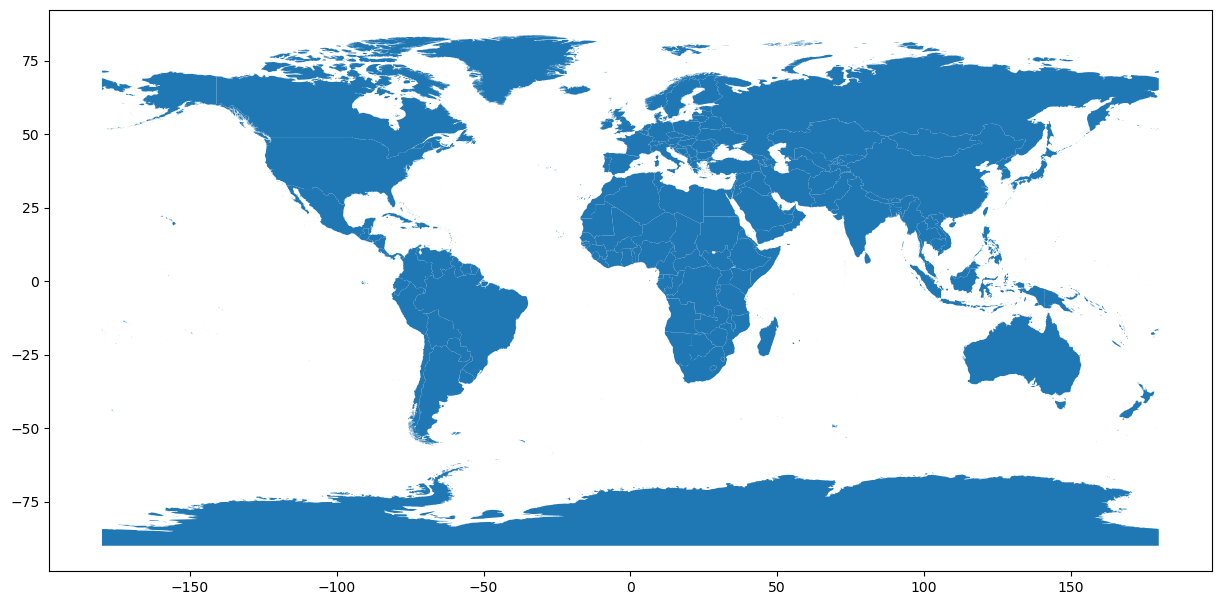

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
world = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Create a new figure with specified size (width, height)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map
world.plot(ax=ax)

# Show the plot
plt.show()



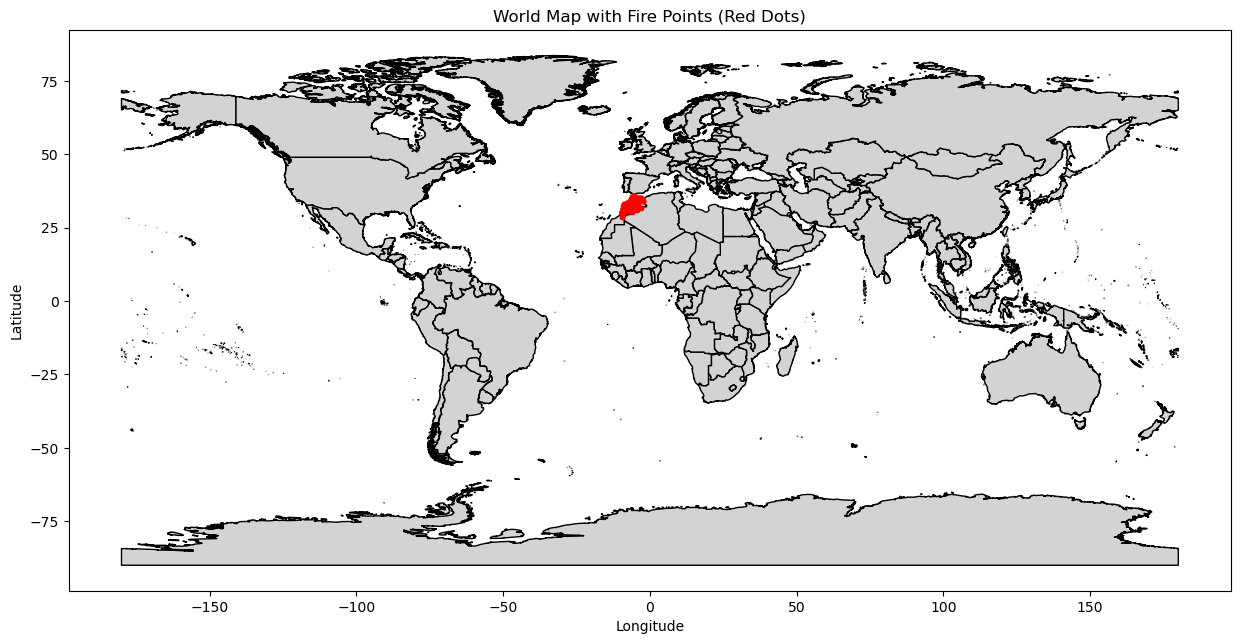

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
world = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Prepare your pandas dataframe (assuming it's called 'df')
# Ensure 'latitude' and 'longitude' columns exist

# Select rows with valid latitude and longitude values (avoid potential errors)
df_filtered = df[df['latitude'].notna() & df['longitude'].notna()]

# Create a GeoDataFrame from the filtered dataframe
geometry = gpd.points_from_xy(df_filtered['longitude'], df_filtered['latitude'])
fire_points = gpd.GeoDataFrame(df_filtered, geometry=geometry)

# Create a new figure with specified size (width, height)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map (world) with a base layer for better visualization (optional)
world.plot(ax=ax, color='lightgray', edgecolor='black')  # Adjust colors as needed

# Plot the fire points as red dots
fire_points.plot(ax=ax, marker='o', color='red', markersize=10)  # Adjust marker size

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('World Map with Fire Points (Red Dots)')

# Show the plot
plt.show()


In [113]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile (world map)
world = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Create a GeoDataFrame with your data (assuming you have a pandas DataFrame df)
# Example data (replace with your actual data):
# data = {
#     'latitude': [32.8068, 31.8242],
#     'longitude': [-4.0153, -2.9432]
# }
data =df[df['latitude'].notna() & df['longitude'].notna()]
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']))

# Create a new figure with specified size (width, height)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map
world.plot(ax=ax)

# Add red dots (scatter plot)
gdf.plot(ax=ax, color='red', markersize=1, label='Modis Fires in 2022')

# Show the plot
plt.legend()
plt.show()


KeyError: 'latitude'

NameError: name 'df' is not defined

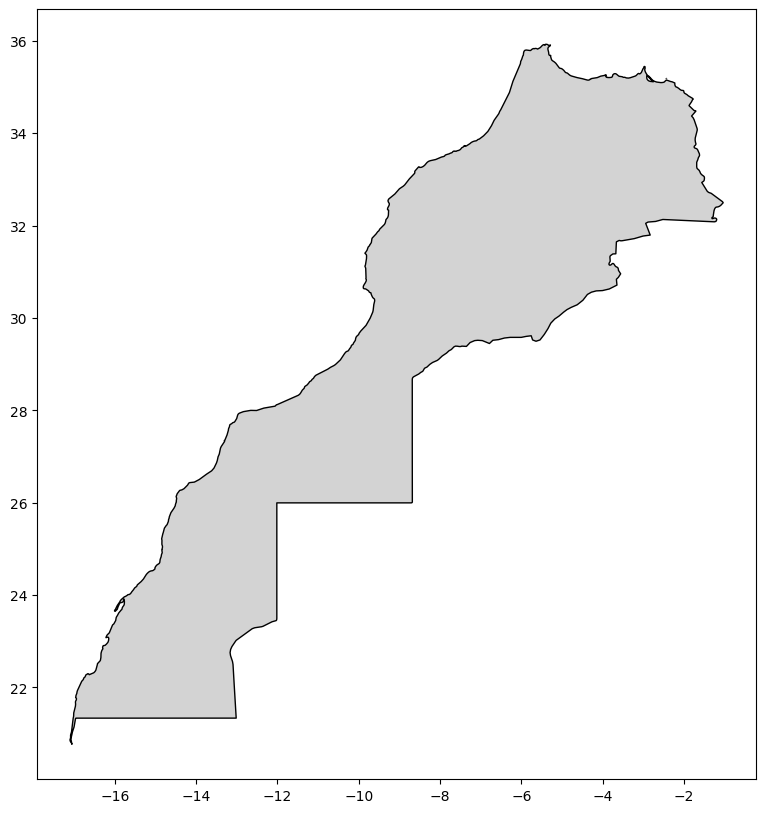

In [111]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile (world map)
world = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Create a new figure with specified size (width, height)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Filter the world GeoDataFrame to include only Morocco
morocco = world[world['ADMIN'] == 'Morocco']

# Plot the Morocco map
morocco.plot(ax=ax, color='lightgray', edgecolor='black')

# Add red dots (scatter plot) if you have specific coordinates
# Example data (replace with your actual data):
data =df[df['latitude'].notna() & df['longitude'].notna()]

gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']))
gdf.plot(ax=ax, color='red', markersize=50, label='Red Dots')

# Show the plot
plt.legend()
plt.title("Map of Morocco")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


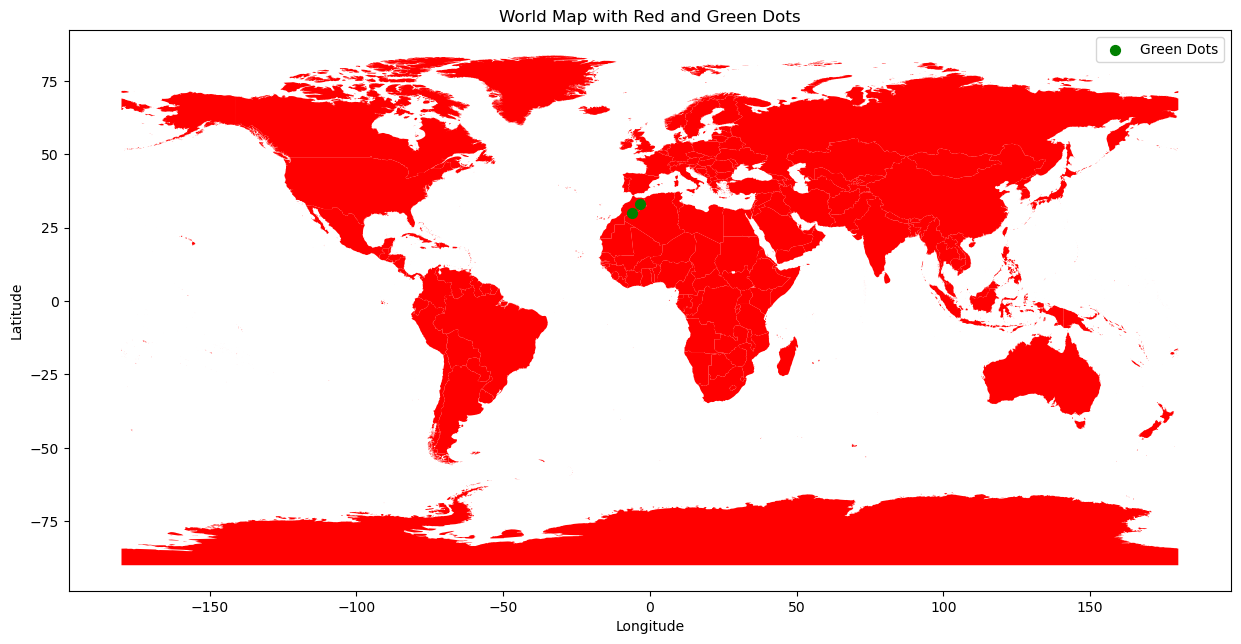

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile (world map)
world = gpd.read_file("./Data/GeoData/SHP/ne_10m_admin_0_countries_mar.shp")

# Create a GeoDataFrame with your data (assuming you have a pandas DataFrame df)
# Example data (replace with your actual data):
data = {
    'latitude': [32.8068, 31.8242],
    'longitude': [-4.0153, -2.9432]
}
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']))

# Create another GeoDataFrame for data2 (replace with your actual data2):
data2 = {
    'latitude': [30.0, 33.0],
    'longitude': [-6.0, -3.5]
}
gdf2 = gpd.GeoDataFrame(data2, geometry=gpd.points_from_xy(data2['longitude'], data2['latitude']))

# Create a new figure with specified size (width, height)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map (in red)
world.plot(ax=ax, color='red')

# Add green dots (scatter plot) for data2
gdf2.plot(ax=ax, color='green', markersize=50, label='Green Dots')

# Show the plot
plt.legend()
plt.title("World Map with Red and Green Dots")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
